In [1]:
import subprocess
import sys
import torch

# Install packages silently
subprocess.run([sys.executable, "-m", "pip", "install", "gdown", "-q"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run([sys.executable, "-m", "gdown", "--id", "1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr", "-O", "filename", "-q"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run([sys.executable, "-m", "pip", "install", "h5py", "-q"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run([sys.executable, "-m", "pip", "install", "torch_geometric", "-q"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run([sys.executable, "-m", "pip", "install", "torch_sparse", "torch_scatter", "torch_cluster", "torch_spline_conv", "-f", f"https://data.pyg.org/whl/torch-{torch.__version__.split('+')[0]}+cpu.html", "-q"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', 'install', 'torch_sparse', 'torch_scatter', 'torch_cluster', 'torch_spline_conv', '-f', 'https://data.pyg.org/whl/torch-2.5.1+cpu.html', '-q'], returncode=0)

In [2]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from sklearn.neighbors import radius_neighbors_graph
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, roc_curve, auc
import gc
import matplotlib.pyplot as plt

# 1. Memory-Efficient Graph Creation

In [3]:
def process_in_chunks(h5_path, chunk_size=30000, threshold=0.01):
    """Process HDF5 file in chunks to save memory"""
    all_graphs = []
    with h5py.File(h5_path, 'r') as f:
        total_jets = f['X_jets'].shape[0]
        
        for start_idx in tqdm(range(0, total_jets, chunk_size), 
                          desc="Processing chunks"):
            end_idx = min(start_idx + chunk_size, total_jets)
            
            # Load chunk
            X_chunk = f['X_jets'][start_idx:end_idx]
            m0_chunk = f['m0'][start_idx:end_idx]
            pt_chunk = f['pt'][start_idx:end_idx]
            y_chunk = f['y'][start_idx:end_idx]
            
            # Process chunk
            chunk_graphs = []
            for i in range(X_chunk.shape[0]):
                data = multi_channel_image_to_graph(
                    X_chunk[i,0], X_chunk[i,1], X_chunk[i,2], threshold)
                data.m0 = torch.tensor([m0_chunk[i]], dtype=torch.float)
                data.pt = torch.tensor([pt_chunk[i]], dtype=torch.float)
                data.y = torch.tensor([int(y_chunk[i])], dtype=torch.long)
                chunk_graphs.append(data)
            
            all_graphs.extend(chunk_graphs)
            
            # Clean up memory
            del X_chunk, m0_chunk, pt_chunk, y_chunk, chunk_graphs
            gc.collect()
    
    return all_graphs


# 2. Early Stopping Class

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

# 3. Graph Construction 

In [5]:
def multi_channel_image_to_graph(ecal, hcal, track, threshold=0.01):
    """Convert 3-channel jet image to graph"""
    nodes = []
    height, width = ecal.shape
    
    for i in range(height):
        for j in range(width):
            total_energy = ecal[i,j] + hcal[i,j] + track[i,j]
            if total_energy > threshold:
                nodes.append([
                    i/float(height),   # norm x
                    j/float(width),   # norm y
                    ecal[i,j],        # ECAL
                    hcal[i,j],        # HCAL
                    track[i,j]        # Track
                ])
    
    if len(nodes) == 0:  # Fallback
        combined = ecal + hcal + track
        max_idx = np.unravel_index(np.argmax(combined), combined.shape)
        nodes.append([
            max_idx[0]/float(height), max_idx[1]/float(width),
            ecal[max_idx], hcal[max_idx], track[max_idx]
        ])
    
    nodes = np.array(nodes, dtype=np.float32)
    pos = nodes[:, :2]
    
    if len(nodes) > 1:
        edges = radius_neighbors_graph(pos, radius=0.15, mode='connectivity')
        edge_index = torch.tensor(edges.nonzero(), dtype=torch.long)
    else:
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
    
    return Data(x=torch.tensor(nodes, dtype=torch.float),
                edge_index=edge_index)

# 4. GNN Model

In [6]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')
        self.mlp = nn.Sequential(
            nn.Linear(2*in_channels, out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Linear(out_channels, out_channels)
        )
    
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        return self.mlp(torch.cat([x_i, x_j-x_i], dim=1))

class JetGNN(nn.Module):
    def __init__(self, node_features=5, hidden_dim=64):
        super().__init__()
        self.conv1 = EdgeConv(node_features, hidden_dim)
        self.conv2 = EdgeConv(hidden_dim, hidden_dim)
        self.conv3 = EdgeConv(hidden_dim, hidden_dim)
        self.global_mlp = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.BatchNorm1d(12))
        self.classifier = nn.Sequential(
            nn.Linear(12 + hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 2))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        graph_feat = global_mean_pool(x, batch)
        global_feat = self.global_mlp(torch.stack([data.m0, data.pt], dim=1))
        return self.classifier(torch.cat([graph_feat, global_feat], dim=1))

# 5. Data Loading (First 30,000 jets only)

In [7]:
def load_data(filename, num_jets=30000):
    with h5py.File(filename, 'r') as f:
        X_jets = f['X_jets'][:num_jets]  # Only load first 30,000 jets
        m0 = f['m0'][:num_jets]
        pt = f['pt'][:num_jets]
        y = f['y'][:num_jets]
    return X_jets, m0, pt, y

def create_graph_dataset(X_jets, m0, pt, y, threshold=0.01):
    graphs = []
    num_jets = X_jets.shape[0]
    
    for i in tqdm(range(num_jets), desc="Creating graphs"):
        ecal = X_jets[i, 0, :, :]  # ECAL channel
        hcal = X_jets[i, 1, :, :]  # HCAL channel
        track = X_jets[i, 2, :, :]  # Track channel
        
        data = multi_channel_image_to_graph(ecal, hcal, track, threshold)
        data.m0 = torch.tensor([m0[i]], dtype=torch.float)
        data.pt = torch.tensor([pt[i]], dtype=torch.float)
        data.y = torch.tensor([int(y[i])], dtype=torch.long)
        graphs.append(data)
    
    return graphs

# 6. Training Loop with tqdm

In [8]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    pbar = tqdm(loader, leave=False, desc="Training")
    for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.squeeze())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        correct += (out.argmax(dim=1) == data.y.squeeze()).sum().item()
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{(out.argmax(dim=1) == data.y.squeeze()).float().mean().item():.4f}"
        })
    
    return total_loss/len(loader), correct/len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    all_preds = []
    all_targets = []
    pbar = tqdm(loader, leave=False, desc="Validation")
    with torch.no_grad():
        for data in pbar:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y.squeeze())
            total_loss += loss.item()
            correct += (out.argmax(dim=1) == data.y.squeeze()).sum().item()
            
            # Store predictions and targets for AUC calculation
            probs = F.softmax(out, dim=1)
            all_preds.append(probs[:, 1].cpu().numpy())  # Probability of class 1
            all_targets.append(data.y.squeeze().cpu().numpy())
            
            pbar.set_postfix({
                'val_loss': f"{loss.item():.4f}",
                'val_acc': f"{(out.argmax(dim=1) == data.y.squeeze()).float().mean().item():.4f}"
            })
    
    # Calculate AUC
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    auc_score = roc_auc_score(all_targets, all_preds)
    
    return total_loss/len(loader), correct/len(loader.dataset), auc_score, all_preds, all_targets

def plot_roc_curve(fpr, tpr, roc_auc, save_path='roc_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig(save_path)
    plt.close()
    print(f"ROC curve saved to '{save_path}'")

# 7. Main Execution

Processing entire dataset in chunks...


Processing chunks:   0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-5-229f6cdee0ed>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor(edges.nonzero(), dtype=torch.long)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 001
Train Loss: 0.6197 | Train Acc: 0.6611
Val Loss: 0.6139 | Val Acc: 0.6634 | Val AUC: 0.7285
Best AUC: 0.7285
LR: 1.00e-03


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 002
Train Loss: 0.6172 | Train Acc: 0.6625
Val Loss: 0.6124 | Val Acc: 0.6673 | Val AUC: 0.7287
Best AUC: 0.7287
LR: 1.00e-03


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 003
Train Loss: 0.6167 | Train Acc: 0.6629
Val Loss: 0.6114 | Val Acc: 0.6691 | Val AUC: 0.7289
Best AUC: 0.7289
LR: 1.00e-03


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 004
Train Loss: 0.6168 | Train Acc: 0.6636
Val Loss: 0.6109 | Val Acc: 0.6689 | Val AUC: 0.7286
Best AUC: 0.7289
LR: 1.00e-03


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 005
Train Loss: 0.6166 | Train Acc: 0.6638
Val Loss: 0.6096 | Val Acc: 0.6699 | Val AUC: 0.7293
Best AUC: 0.7293
LR: 1.00e-03


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 006
Train Loss: 0.6164 | Train Acc: 0.6639
Val Loss: 0.6107 | Val Acc: 0.6674 | Val AUC: 0.7294
Best AUC: 0.7294
LR: 1.00e-03


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 007
Train Loss: 0.6166 | Train Acc: 0.6646
Val Loss: 0.6101 | Val Acc: 0.6707 | Val AUC: 0.7291
Best AUC: 0.7294
LR: 1.00e-03


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 008
Train Loss: 0.6161 | Train Acc: 0.6642
Val Loss: 0.6100 | Val Acc: 0.6690 | Val AUC: 0.7294
Best AUC: 0.7294
LR: 5.00e-04


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 009
Train Loss: 0.6160 | Train Acc: 0.6640
Val Loss: 0.6097 | Val Acc: 0.6694 | Val AUC: 0.7291
Best AUC: 0.7294
LR: 5.00e-04


Training:   0%|          | 0/3483 [00:00<?, ?it/s]

Validation:   0%|          | 0/871 [00:00<?, ?it/s]


Epoch 010
Train Loss: 0.6158 | Train Acc: 0.6641
Val Loss: 0.6096 | Val Acc: 0.6695 | Val AUC: 0.7295
Best AUC: 0.7295
LR: 5.00e-04

Early stopping triggered

Training complete. Best model saved to 'best_jetgnn.pt'
Best AUC during training: 0.7295


<ipython-input-9-d7b9f8a730df>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_jetgnn.pt'))


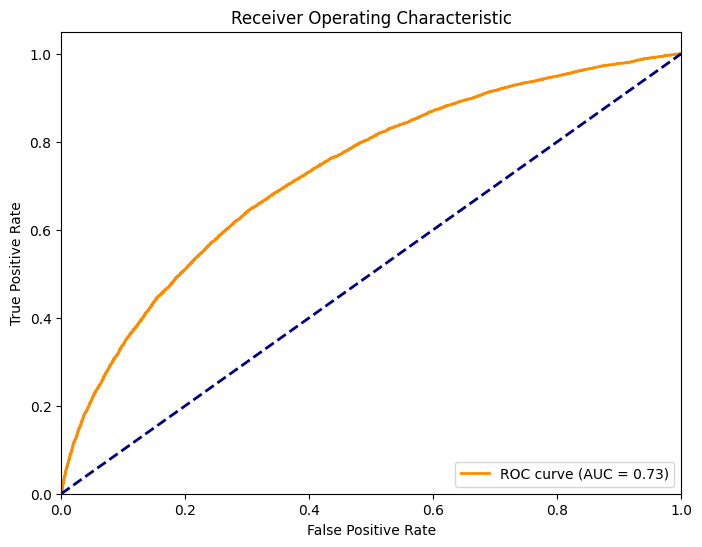

ROC curve saved to 'roc_curve.png'


In [9]:
def main():
    # Config
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    threshold = 0.01
    patience = 5
    lr = 0.001
    batch_size = 32
    hidden_dim = 128
    chunk_size = 30000  # Process 30,000 jets at a time
    
    # Process data in chunks
    print("Processing entire dataset in chunks...")
    graphs = process_in_chunks('/kaggle/working/filename', chunk_size, threshold)
    
    # Split data
    train_graphs, val_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
    del graphs  # Free memory
    gc.collect()
    
    # Create dataloaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=batch_size)
    
    # Initialize model
    model = JetGNN(hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=patience, path='best_jetgnn.pt')
    
    # Training loop
    best_auc = 0.0
    best_val_preds = None
    best_val_targets = None
    
    for epoch in range(100):
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validation
        val_loss, val_acc, val_auc, val_preds, val_targets = validate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Track best AUC and predictions
        if val_auc > best_auc:
            best_auc = val_auc
            best_val_preds = val_preds
            best_val_targets = val_targets
            torch.save(model.state_dict(), 'best_jetgnn_auc.pt')
        
        # Print epoch stats
        print(f"\nEpoch {epoch+1:03d}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
        print(f"Best AUC: {best_auc:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("\nEarly stopping triggered")
            break
    
    # Load best model (based on validation loss)
    model.load_state_dict(torch.load('best_jetgnn.pt'))
    print("\nTraining complete. Best model saved to 'best_jetgnn.pt'")
    print(f"Best AUC during training: {best_auc:.4f}")
    
    # Plot ROC curve for best validation performance
    if best_val_preds is not None and best_val_targets is not None:
        fpr, tpr, _ = roc_curve(best_val_targets, best_val_preds)
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc)

if __name__ == "__main__":
    main()